#データロード

In [0]:
import cv2
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.layers import Activation, BatchNormalization, Conv2D
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras import backend as K
from keras.applications import MobileNetV2
from keras.layers import Concatenate, MaxPool2D, Conv2DTranspose, Add

# dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#学習データ
x_train_h, x_ref, y_ref = [], [], []

for i in range(len(x_train)):
    if y_train[i] == 7:#馬は7
        x_train_h.append(x_train[i])
    if y_train[i] == 4:#鹿は4
        pass
    else:
        x_ref.append(x_train[i])
        y_ref.append(y_train[i])

#refデータからランダムに6000個抽出
number = np.random.choice(np.arange(0,len(x_ref)),6000,replace=False)

x, y = [], []

for i in number:
    x.append(x_ref[i])
    y.append(y_ref[i])
    
x_train_h = np.array(x_train_h)
x_ref = np.array(x)
y_ref = to_categorical(y)

#テストデータ
x_test_h, x_test_d = [], []

for i in range(len(x_test)):
    if y_test[i] == 7:#馬は7
        x_test_h.append(x_test[i])
    
    if y_test[i] == 4:#鹿は4
        x_test_d.append(x_test[i])
    
x_test_h = np.array(x_test_h)
x_test_d = np.array(x_test_d)

print(x_train_h.shape)
print(x_ref.shape)
print(y_ref.shape)

Using TensorFlow backend.


170500096/170498071 [==============================] - 4s 0us/step
(5000, 32, 32, 3)
(6000, 32, 32, 3)
(6000, 10)


#96 * 96 * 3にリサイズ

In [0]:
Height = 96
Width = 96
channel = 3

def resize(x):
    x_out = []
    
    for i in range(len(x)):
        img = cv2.resize(x[i], dsize=(Width, Height))
        x_out.append(img)
                
    return np.array(x_out)

X_train_h = resize(x_train_h)
X_ref = resize(x_ref)
X_test_h = resize(x_test_h)
X_test_d = resize(x_test_d)

#L2 softmax loss

In [0]:
classes = 10
alpha_ = 5

mobile = MobileNetV2(include_top=True, input_shape=X_ref.shape[1:], alpha=0.5,
                     weights='imagenet')
    
# 最終層削除
mobile.layers.pop()
f_model = Model(inputs=mobile.input,outputs=mobile.layers[-1].output)
            
# L2層と全結合層を付ける
c = keras.layers.Lambda(lambda xx: alpha_*(xx)/K.sqrt(K.sum(xx**2)))(f_model.output) #metric learning
c = Dense(classes, activation='softmax')(c)
f_model = Model(inputs=f_model.input,outputs=c)

f_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001, amsgrad=True),
              metrics=['accuracy'])
    
hist = f_model.fit(X_ref,
                   y_ref,
                   batch_size=128,
                   epochs=30,
                   verbose = True)

W0722 02:18:02.971597 140394267404160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
6000/6000 [==============================] - 21s 4ms/step - loss: 2.2540 - acc: 0.5428
Epoch 2/30
6000/6000 [==============================] - 9s 2ms/step - loss: 2.1127 - acc: 0.7743
Epoch 3/30
6000/6000 [==============================] - 9s 2ms/step - loss: 1.9988 - acc: 0.8203
Epoch 4/30
6000/6000 [==============================] - 9s 2ms/step - loss: 1.9137 - acc: 0.8673
Epoch 5/30
6000/6000 [==============================] - 9s 2ms/step - loss: 1.8393 - acc: 0.8978
Epoch 6/30
6000/6000 [==============================] - 9s 2ms/step - loss: 1.7701 - acc: 0.9255
Epoch 7/30
6000/6000 [==============================] - 9s 2ms/step - loss: 1.7060 - acc: 0.9412
Epoch 8/30
6000/6000 [==============================] - 9s 2ms/step - loss: 1.6431 - acc: 0.9578
Epoch 9/30
6000/6000 [==============================] - 9s 2ms/step - loss: 1.5825 - acc: 0.9708
Epoch 10/30
6000/6000 [==============================] - 9s 2ms/step - loss: 1.5262 - acc: 0.9793
Epoch 11/30
6000/6000 [=====

In [0]:
# 最終層削除
f_model.layers.pop()

f_model = Model(inputs=f_model.input,outputs=f_model.layers[-1].output, name="f_net")
#model.summary()

#Unet

In [0]:
epochs = 150
beta = 50

feature_out = 1280

## UNet
def create_block(input, chs):
    x = input
    for i in range(2):
        x = Conv2D(chs, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

def create_unet():
    inputs = Input((96,96,3))
    
    # Encoder
    block1 = create_block(inputs, 64)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 128)
    x = MaxPool2D(2)(block2)
    block3 = create_block(x, 256)
    x = MaxPool2D(2)(block3)
    block4 = create_block(x, 512)
    # Middle
    x = MaxPool2D(2)(block4)
    x = create_block(x, 1024)
    # Decoder
    x = Conv2DTranspose(512, kernel_size=2, strides=2)(x)
    x = Concatenate()([block4, x])
    x = create_block(x, 512)
    x = Conv2DTranspose(256, kernel_size=2, strides=2)(x)
    x = Concatenate()([block3, x])
    x = create_block(x, 256)
    x = Conv2DTranspose(128, kernel_size=2, strides=2)(x)
    x = Concatenate()([block2, x])
    x = create_block(x, 128)
    x = Conv2DTranspose(64, kernel_size=2, strides=2)(x)
    x = Concatenate()([block1, x])
    x = create_block(x, 64)
    # output
    x = Conv2D(3, 1)(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x, name="u_net")

# loss function
def loss_function(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def train_model(f_net, x_train, test_sample):
    # build unet
    print("Build model")
    input_u = Input(shape=(96,96,3))
    unet = create_unet()
    u_out = unet(input_u)
    
    # freeze f_net weight
    f_net.trainable = False
    f_out= f_net(u_out)    
    
    # Concatenate u_net and f_net
    uf_net = Model(inputs=input_u, outputs=[u_out, f_out])
    
    # compile
    opt = tf.train.MomentumOptimizer(1e-3, 0.9)
    uf_net.compile(loss=loss_function, loss_weights= [1, beta], optimizer=opt)

    # f_net center
    test_sample = test_sample.reshape((1, Height, Width, channel))
    center = np.mean(f_net.predict(x_train), axis=0).reshape((1,-1))

    print("Train model")
    hist = uf_net.fit(test_sample, [test_sample, center],
                      batch_size=1,
                      verbose = False,
                      epochs=epochs)
    
    return uf_net
  
def plot3_1(x, x_predict):
    plt.figure(figsize=(9,3))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.axis("off")
    plt.imshow(x)
    
    plt.subplot(1, 3, 2)
    plt.title("Reconstruction")
    plt.axis("off")
    x_predict = np.array(x_predict).reshape((Height, Width, channel))
    plt.imshow(x_predict)

    plt.subplot(1, 3, 3)
    map_ = np.abs(x-x_predict).reshape((96,96,3))
    jet = cv2.applyColorMap(np.uint8(255 * map_), cv2.COLORMAP_JET)  # 疑似的に色をつける
    jet = cv2.cvtColor(jet, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jet = (np.float32(jet) + x*255 / 2)   # もとの画像に合成
    plt.imshow(array_to_img(jet))
    plt.title("HeatMap")
    plt.axis("off")

    plt.show()

#Ano-Unetで描画

10
Build model
Train model


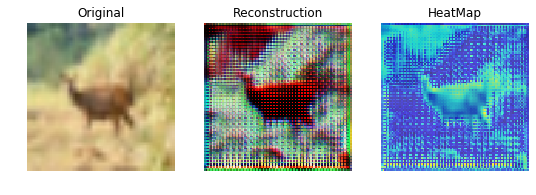

11
Build model
Train model


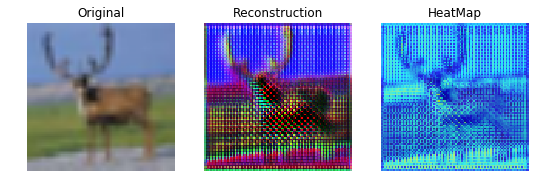

12
Build model
Train model


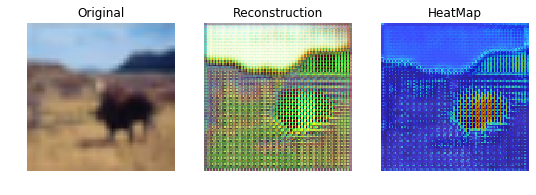

13
Build model


In [0]:
for i in range(10,100):
  print(i)
  test_sample = X_test_d[i]

  uf_net = train_model(f_model, X_train_h, test_sample)
  x_predict, _ = uf_net.predict(test_sample.reshape((1,Height,Width,channel)))

  plot3_1(test_sample, x_predict)